In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image
from collections import namedtuple
import time
import os
from dzlib.utils.helper import info, stats, params, npshow, janimate, ccrop_pil, resize_pil
from dzlib.nn_models.unet_dip import UNet_DIP
from dzlib.nn_models.dipnet import DIPNet

print(f"Imports Complete")

Imports Complete


In [2]:
# General Settings
dtype = torch.FloatTensor
%matplotlib notebook
matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['figure.dpi'] = 80
# %config InlineBackend.print_figure_kwargs={'bbox_inches':None}


## Load PIL, Center-Crop, Downscale

In [3]:
# Load PIL Image
data_dir = os.getcwd() + "/data/license_plates"
fn = data_dir + "/test4.jpg"
image_pil = Image.open(fn)
print(f"Original PIL Image Size: {image_pil.size}")

# Center Crop dims to be divisible by 32
image_pil_HR = ccrop_pil(image_pil, factor=32)
print(f"Center-Cropped PIL Image Size: {image_pil_HR.size}")

# Downscale dims by 4
image_pil_LR = resize_pil(image_pil_HR, factor=0.25, resample=Image.ANTIALIAS)
width, height = image_pil_LR.size
print(f"Downscaled PIL Image Size: {image_pil_LR.size}")



Original PIL Image Size: (480, 240)
Center-Cropped PIL Image Size: (480, 224)
Downscaled PIL Image Size: (120, 56)


## Convert to Numpy & Plot
### Numpy, Float32, Transpose to (C x H x W), Normalize values to 0-1

torch.Size([3, 224, 480])


<IPython.core.display.Javascript object>


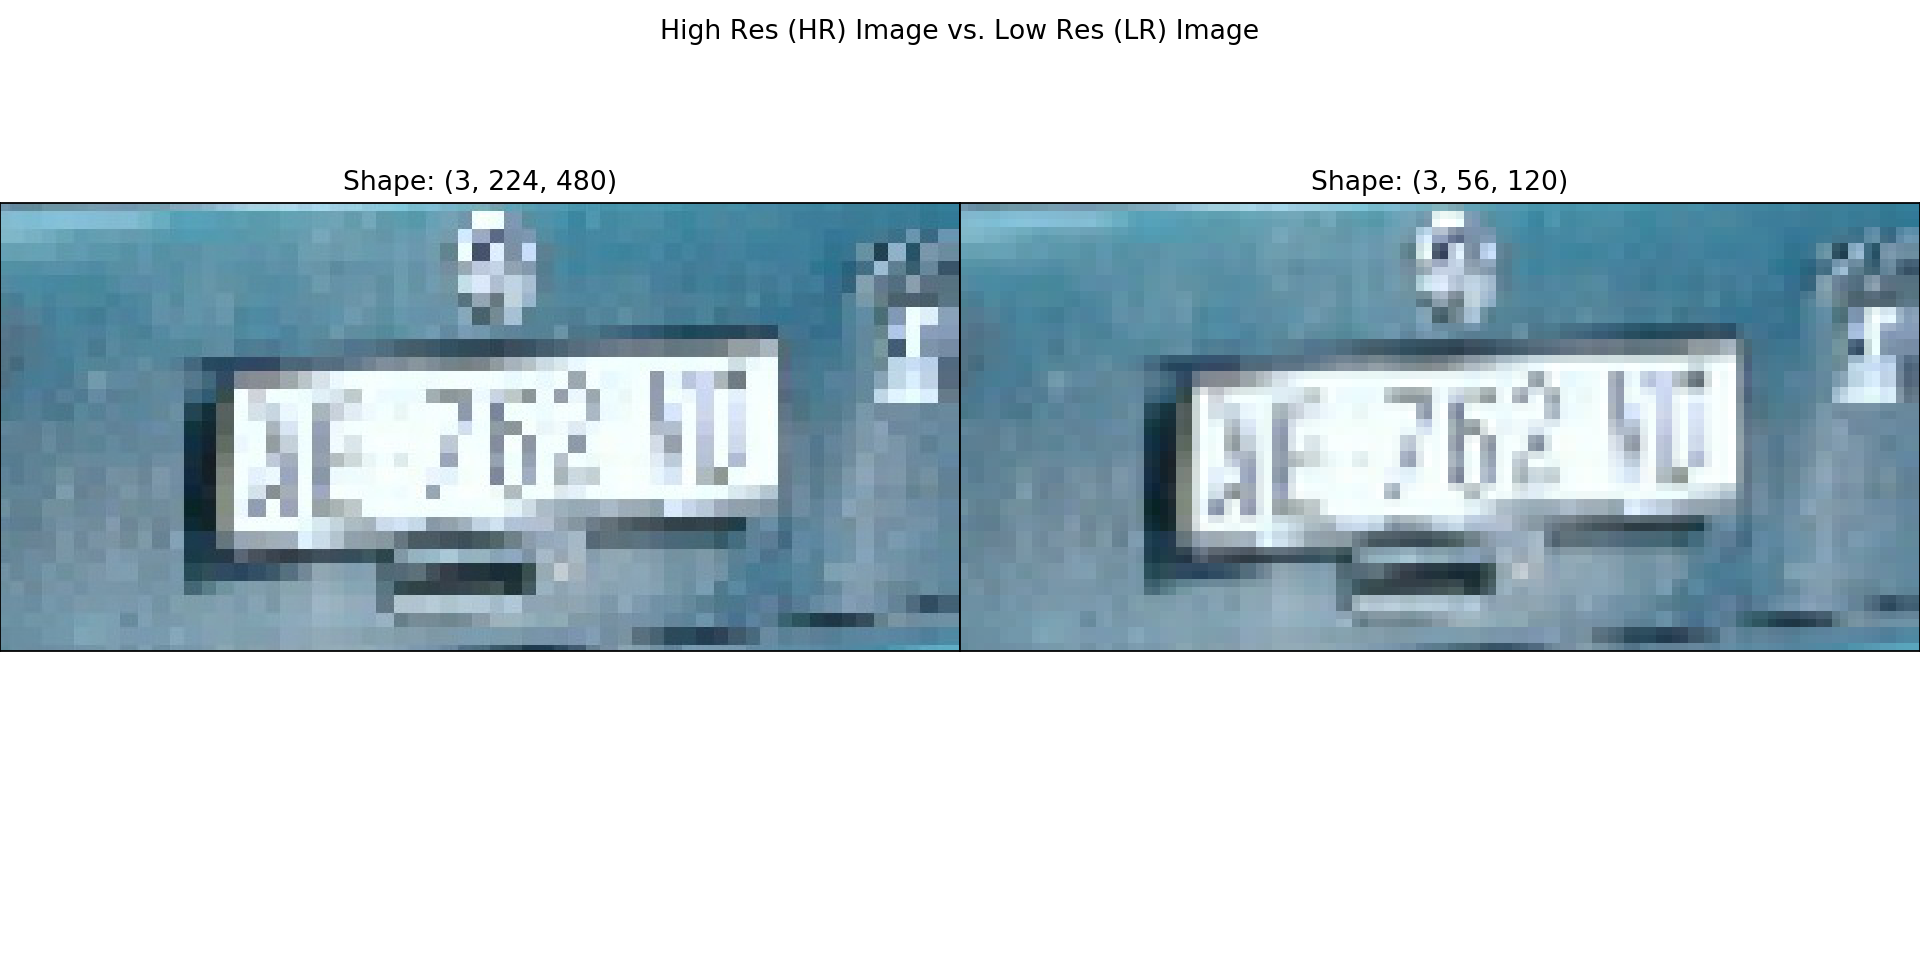

In [4]:
Dims = namedtuple('Dims', 'channels height width')

# HR = High-Res, LR = Low-Res
image_np_HR = np.asarray(image_pil_HR).astype(np.int32).transpose(2, 0, 1) / 255
image_np_LR = np.asarray(image_pil_LR).astype(np.int32).transpose(2, 0, 1) / 255
image_pt_HR = torch.from_numpy(image_np_HR).type(dtype)
print(image_pt_HR.shape)
images = [image_np_HR, image_np_LR]

# HR and LR dimensions (C, H, W)
HR = Dims(*image_np_HR.shape)
LR = Dims(*image_np_LR.shape)

# Fig, Axes
fig, axes = plt.subplots(1, figsize=(12, 6), ncols=2, constrained_layout=True)
fig.suptitle(f"High Res (HR) Image vs. Low Res (LR) Image")
fig.subplots_adjust(wspace=0, left=0, right=1, top=1)

[(axis.set_yticks([]), axis.set_xticks([])) for axis in axes]
[axis.set_title(f'Shape: {image.shape}') for image, axis in zip(images, axes)]
[npshow(image, axis) for image, axis in zip(images, axes)];


## Net Input & Target


Net Input info:
dtype: torch.float32
shape: torch.Size([1, 32, 224, 480])

Net Input stats:
max:  0.1000
min:  0.0000
mean: 0.0500
std:  0.0289

Net Target info:
dtype: torch.float32
shape: torch.Size([1, 3, 56, 120])

Net Target stats:
max:  1.0000
min:  0.0275
mean: 0.5882
std:  0.2075


<IPython.core.display.Javascript object>


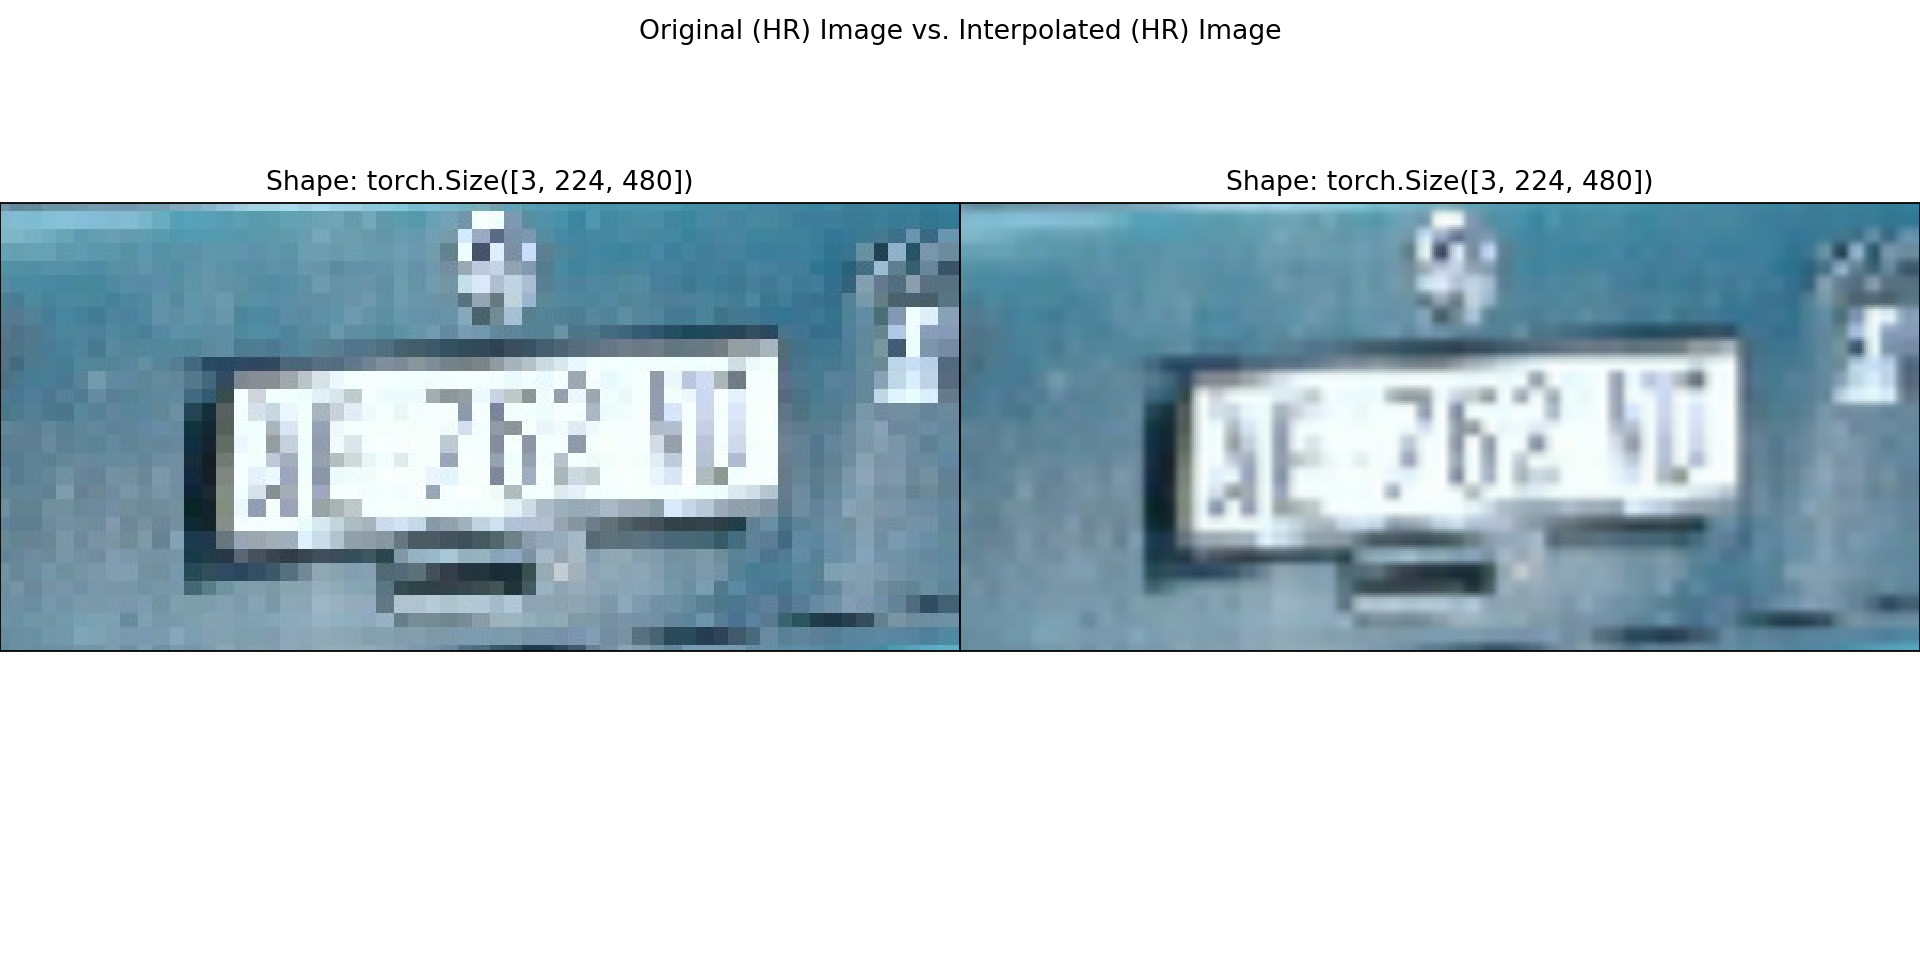

In [5]:
# Net Input Type: Uniform Noise
# Net Input Shape: (1 x C x H x W), where C = 32; H, W = HR Dimensions
ninput_channels = 32
ninput = torch.zeros(1, ninput_channels, HR.height, HR.width)
std_scaler = 1./10.
ninput = ninput.uniform_() * std_scaler
ninput = ninput.type(dtype)

# Target Type: LR Image
# Target Shape: (1 x C x H x W), where C, H, W = LR Dimensions
target = torch.from_numpy(image_np_LR).view(1, LR.channels, LR.height, LR.width).type(dtype)
target_plot = target.detach().cpu()[0]

# Net Input
info(ninput, 'Net Input')
stats(ninput, 'Net Input')

# Target
info(target, 'Net Target')
stats(target, 'Net Target')

# Create Interpolated HR Image from Target
image_pt_HR_interpolated = F.interpolate(input=target, size=(HR.height, HR.width), mode='bilinear')[0]
images = [image_pt_HR, image_pt_HR_interpolated]

# Plot Original HR Image vs Interpolated HR Image
fig, axes = plt.subplots(1, figsize=(12, 6), ncols=2, constrained_layout=True)
fig.suptitle(f"Original (HR) Image vs. Interpolated (HR) Image")
fig.subplots_adjust(wspace=0, left=0, right=1, top=1)

[(axis.set_yticks([]), axis.set_xticks([])) for axis in axes]
[axis.set_title(f'Shape: {image.shape}') for image, axis in zip(images, axes)]
[npshow(image, axis) for image, axis in zip(images, axes)];


In [7]:
info(image_pt_HR)
info(image_pt_HR_interpolated)


var info:
dtype: torch.float32
shape: torch.Size([3, 224, 480])

var info:
dtype: torch.float32
shape: torch.Size([3, 224, 480])


# DIPNet

In [8]:
# # Note on Conv Params:
# # padding_mode (pad) is set to 'reflect'
# # Padding Amount is NOT passed as a parameter. It is automatically calculated to keep image dimensions the same, such that the only factor in determining the output dimensions is the stride. Stride of 1 results in output dimensions being same, stride of 2 results in output dimensions being halved.

# pad = 'reflect'

# # DIPNet Input Args
# in_channels = ninput_channels
# out_channels = LR.channels

# down_channels = [8, 16, 32, 64, 128]
# skip_channels = [0, 0,  0,  4,  4]
# up_channels =   [8, 16, 32, 64, 128]

# down_conv1 = DIPNet.Conv(3, 2, pad) # Downscales H, W by 2
# down_conv2 = DIPNet.Conv(3, 1, pad)
# down_convs = [down_conv1, down_conv2]

# skip_conv1 = DIPNet.Conv(1, 1, pad)
# skip_convs = [skip_conv1]

# up_conv1 = DIPNet.Conv(3, 1, pad)
# up_conv2 = DIPNet.Conv(1, 1, pad)
# up_convs = [up_conv1, up_conv2]

# batchnorm = True
# last_batchnorm = False

# activation = 'leakyrelu'
# last_activation = 'sigmoid'

# upsample = DIPNet.Upsample(size=None, scale_factor=2, mode='bilinear', align_corners=None) # Upscales H, W by 2

# # Create DIPNet
# net = DIPNet(in_channels, out_channels, \
#            down_channels, skip_channels, up_channels, \
#            down_convs, skip_convs, up_convs, \
#            batchnorm, last_batchnorm, \
#            activation, last_activation, \
#            upsample)
# net = net.type(dtype)
# name = net.__class__.__name__
# # Number of Params
# n_params = params(net)
# print(f"{(n_params/1e6):.2f} Million Params in {net.__class__.__name__}")


# UNet Params

In [9]:
in_channels = ninput_channels
out_channels = LR.channels

encoder_channels = [8, 16, 32, 64, 128]
kernel_sizes = [3, 3]
kernel_strides = [1, 1]
maxpool_size = 2
maxpool_stride = 2


net = UNet_DIP(in_channels, out_channels, encoder_channels, kernel_sizes, kernel_strides, maxpool_size, maxpool_stride)
net = net.type(dtype)
ninput = net.pad2d(ninput)
name = net.__class__.__name__

# Number of Params
n_params = params(net)
print(f"{(n_params/1e6):.2f} Million Params in {net.__class__.__name__}")





0.48 Million Params in UNet_DIP


## Training Params

In [10]:
# Iterations
n_iters = 2000

losses = []
mse = nn.MSELoss().type(dtype)
lr = 0.01
optimizer = optim.Adam(net.parameters(), lr=lr)

# For Regularization
reg_noise_std = 0.03
ninput_saved = ninput.detach().clone()
noise = ninput.detach().clone()


## Directory and filenames for saved outputs

In [11]:
# Make directory for saved output images (will not overwrite existing directory)
cwd = os.getcwd()
run = '/run6'
try:
    save_path = cwd + '/outputs/' + name + run
    os.mkdir(save_path)    
except:
    save_path = cwd + '/outputs/' + name
    os.mkdir(save_path)
    save_path = cwd + '/outputs/' + name + run
    os.mkdir(save_path)    
# os.mkdir(save_path + '/LR')    
# os.mkdir(save_path + '/HR')            
print(f"Saving to: {save_path}")

# Make list of filenames for saved output images
extension = 'png'
digits = len(str(n_iters))
filenames = [f"{save_path}/{i+1:0{digits}d}.{extension}" for i in range(n_iters)]
# filenames_LR = [f"{save_path + '/LR'}/{i+1:0{digits}d}.{extension}" for i in range(n_iters)]
# filenames_HR = [f"{save_path + '/HR'}/{i+1:0{digits}d}.{extension}" for i in range(n_iters)]


Saving to: /Users/dziyaee/code/dzcode/dz_deep_image_prior/outputs/UNet_DIP/run6


## Set up figs, axes for real-time plots

<IPython.core.display.Javascript object>


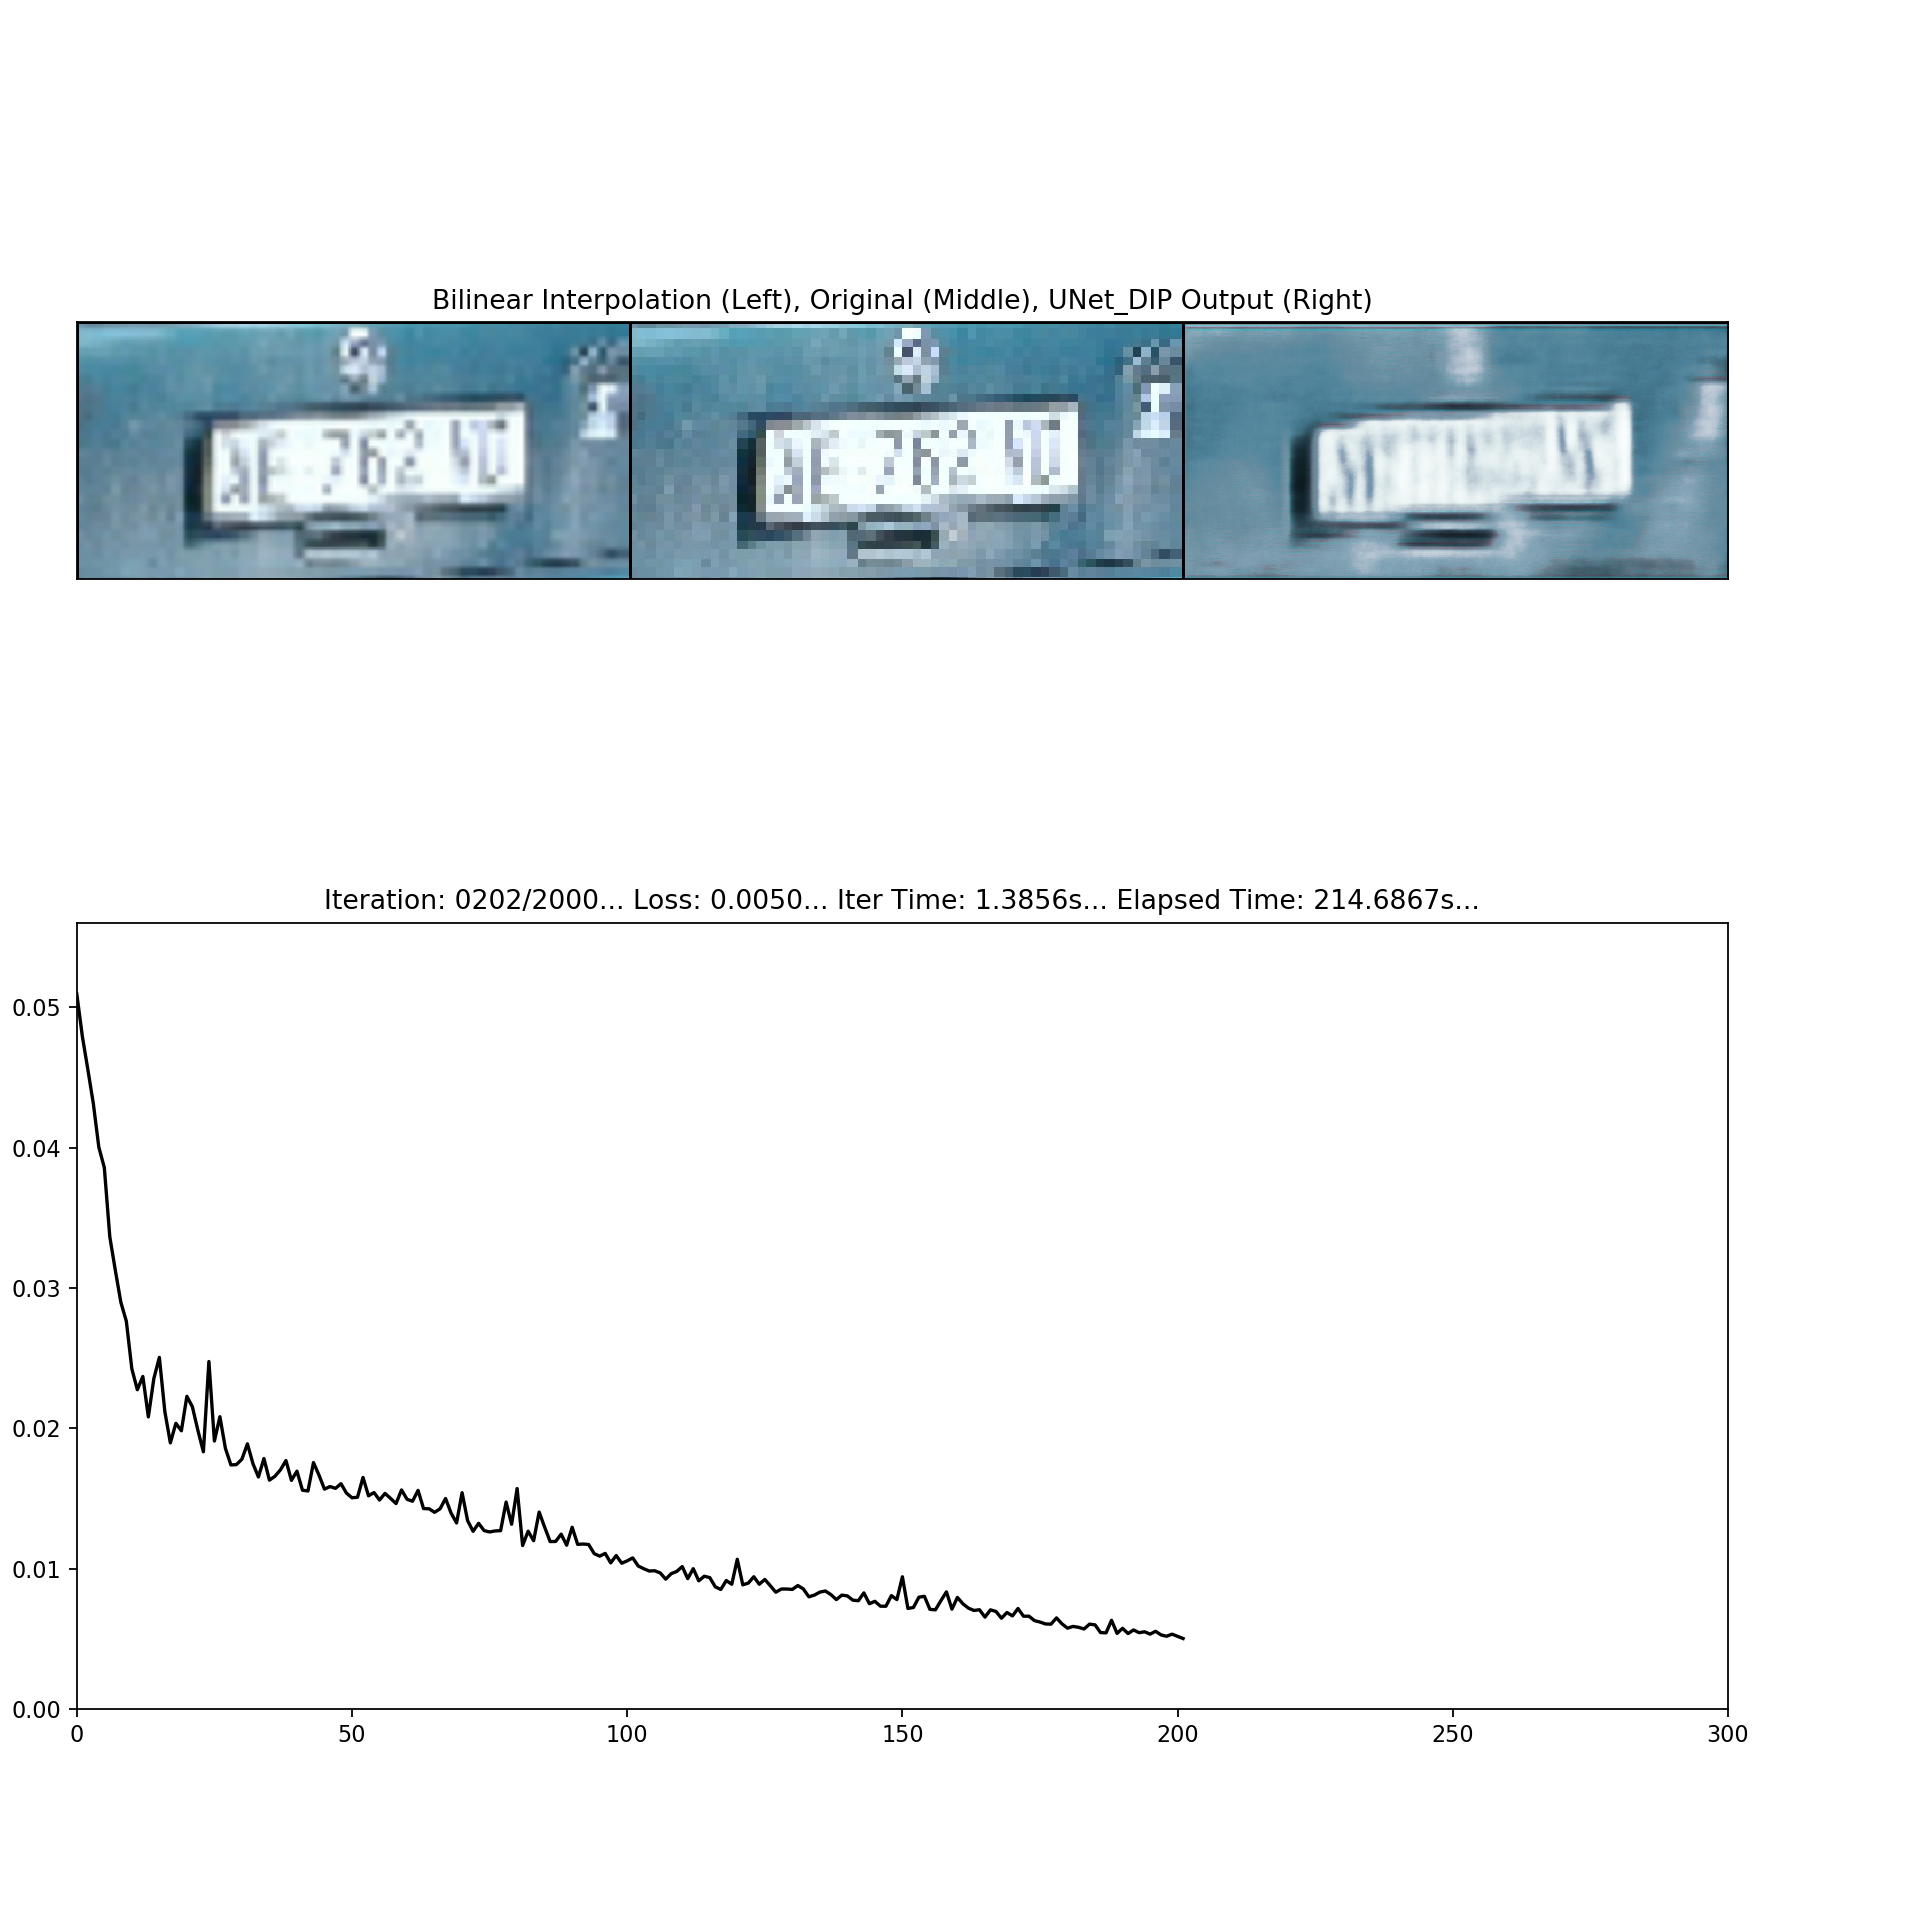

In [12]:
# Figure and axes
fig_kwargs = {'frameon': False, 'linewidth': 4, 'edgecolor': 'red'}
fig = plt.figure(figsize=(12, 12), **fig_kwargs)
gs = GridSpec(nrows=2, ncols=1, figure=fig, left=0.04, hspace=0.1, top=0.97, wspace=0)
ax1 = fig.add_subplot(gs[:1, :])
ax2 = fig.add_subplot(gs[1:, :])

for axis, title in zip([ax1], [f'Bilinear Interpolation (Left), Original (Middle), {name} Output (Right)']):
    axis.set_xlim(0, HR.width*3)
    axis.set_ylim(HR.height, 0)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(title)
ax1_kwargs = {'interpolation': None}


ax2_kwargs = {'color': 'k'}

# removes axes objects during animation (for performance reasons, can set to False on last iteration to hold plot)
remove = True


In [13]:

iter_times = []
start_time = time.time()
for i in range(n_iters):
    iter_time = time.time()
    
    # Start Training Phase -----
    # zero grad
    optimizer.zero_grad()
    
    # regularization of input
    ninput = ninput_saved + noise.normal_() * reg_noise_std
    
    # forward pass to obtain HR output
    out_HR = net(ninput)
    out_HR = net.crop2d(out_HR)
    
    # downsample to obtain LR output
    out_LR = F.interpolate(input=out_HR, size=(target.shape[2], target.shape[3]), mode='bilinear')
    
    # evaluate loss as MSE between LR output and LR Image (target)
    loss = mse(out_LR, target)
    
    # back prop
    loss.backward()
    
    # update params
    optimizer.step()
    # End Training Phase --
    
    # Start Data Capture Phase -----
    
    # Loss
    losses.append(loss.item())
    
    # NP Grid for plotting and saving (Original HR image vs Net output HR image)
    out_HR_plot = out_HR.detach().cpu()[0]
    gridplot_HR = make_grid([image_pt_HR_interpolated, image_pt_HR, out_HR_plot], nrow=3)
    
    # Saves
#     save_image(gridplot_HR, filenames_HR[i])
    save_image(gridplot_HR, filenames[i])
    
    # Hold axes objects on last iteration
    if i == n_iters - 1:
        remove = False
        
    # Extend loss xlim every 100 iters
    if i % 100 == 0:
        ax2.set_xlim(0, i+100)
    
    # Animate
    janimate(fig, [gridplot_HR.permute(1, 2, 0), losses[:i]], [ax1.imshow, ax2.plot], [ax1_kwargs, ax2_kwargs], remove)
    ax2.set_title(f'Iteration: {i+1:0{digits}d}/{n_iters}... Loss: {loss.item():.4f}... Iter Time: {(time.time() - iter_time):.4f}s... Elapsed Time: {(time.time() - start_time):.4f}s...')
    ax2.set_ylim(0, np.max(np.asarray(losses))*1.1)
    # Timing
    iter_times.append(time.time() - iter_time)
    # End Data Capture Phase --

total_time = time.time() - start_time



x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([


x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([1, 32, 56, 120])
sx before cat:   torch.Size([1, 32, 56, 120])
x after cat:     torch.Size([1, 64, 56, 120])

x before deconv: torch.Size([1, 32, 56, 120])
x after deconv:  torch.Size([1, 16, 112, 240])
sx before cat:   torch.Size([1, 16, 112, 240])
x after cat:     torch.Size([1, 32, 112, 240])

x before deconv: torch.Size([1, 16, 112, 240])
x after deconv:  torch.Size([1, 8, 224, 480])
sx before cat:   torch.Size([1, 8, 224, 480])
x after cat:     torch.Size([1, 16, 224, 480])

x before deconv: torch.Size([1, 128, 14, 30])
x after deconv:  torch.Size([1, 64, 28, 60])
sx before cat:   torch.Size([1, 64, 28, 60])
x after cat:     torch.Size([1, 128, 28, 60])

x before deconv: torch.Size([1, 64, 28, 60])
x after deconv:  torch.Size([

KeyboardInterrupt: 